Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5274 - loss: 1.5142 - val_accuracy: 0.6680 - val_loss: 1.1079
Epoch 2/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7383 - loss: 0.8266 - val_accuracy: 0.7291 - val_loss: 0.7986
Epoch 3/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8033 - loss: 0.6249 - val_accuracy: 0.7841 - val_loss: 0.6440
Epoch 4/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8769 - loss: 0.4573 - val_accuracy: 0.8065 - val_loss: 0.4974
Epoch 5/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9501 - loss: 0.3000 - val_accuracy: 0.9022 - val_loss: 0.2946
Epoch 6/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9750 - loss: 0.2159 - val_accuracy: 0.9959 - val_loss: 0.1551
Epoch 7/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9831 - loss: 0.1884 - val_accuracy: 0.9959 - val_loss: 0.1404
Epoch 8/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 0.1587 - val_accuracy: 0.9959 - val

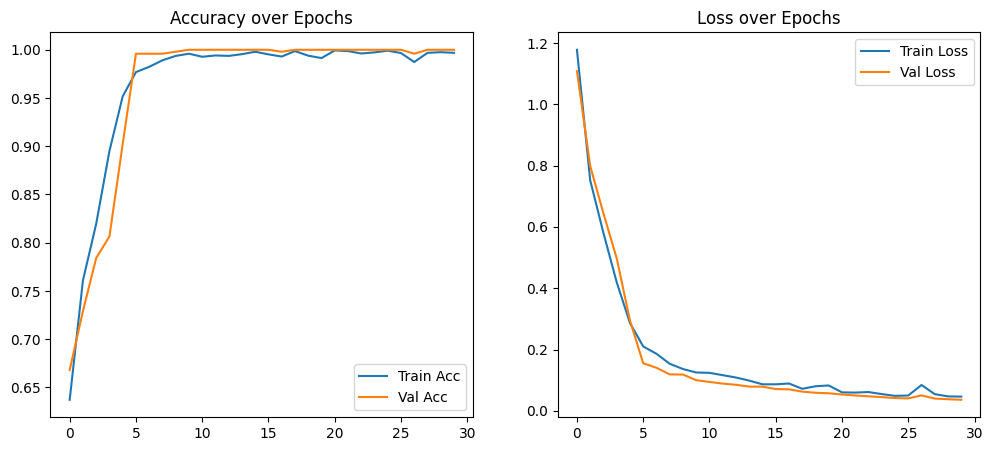

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# Load dataset
df = pd.read_csv("/kaggle/input/dataset-new/esp32_attack_data.csv")

# Drop unnecessary features
df = df.drop(columns=['Source IP', 'Destination IP', 'TCP Flags'])

# Drop missing values
df = df.dropna()

# Encode labels
le = LabelEncoder()
df['Attack Type'] = le.fit_transform(df['Attack Type'])
np.save("label_classes.npy", le.classes_)

# Define features and target
X = df.drop(columns=['Attack Type'])
y = df['Attack Type']

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode target labels
y = to_categorical(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Build an optimized model
model = Sequential([
    Dense(128, input_shape=(X.shape[1],), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.1),

    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Implement K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=30,  # Increased epochs
    batch_size=32,
    verbose=1
)

# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

# Save model
model.save("esp32_attack_model_optimized.h5")
print("\n✅ Model saved as esp32_attack_model_optimized.h5")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Predictions saved to attack_predictions.csv

🎯 Model Accuracy on New Data: 99.94%

🔍 Classification Report:
                   precision    recall  f1-score   support

        DNS Query       0.98      1.00      0.99       100
     HTTP Request       1.00      1.00      1.00       500
Malformed Packets       1.00      1.00      1.00       500
           Normal       1.00      1.00      1.00      3510
        Port Scan       1.00      1.00      1.00      1005
        SYN Flood       1.00      1.00      1.00       500
        UDP Flood       1.00      1.00      1.00       500

         accuracy                           1.00      6615
        macro avg       1.00      1.00      1.00      6615
     weighted avg       1.00      1.00      1.00      6615



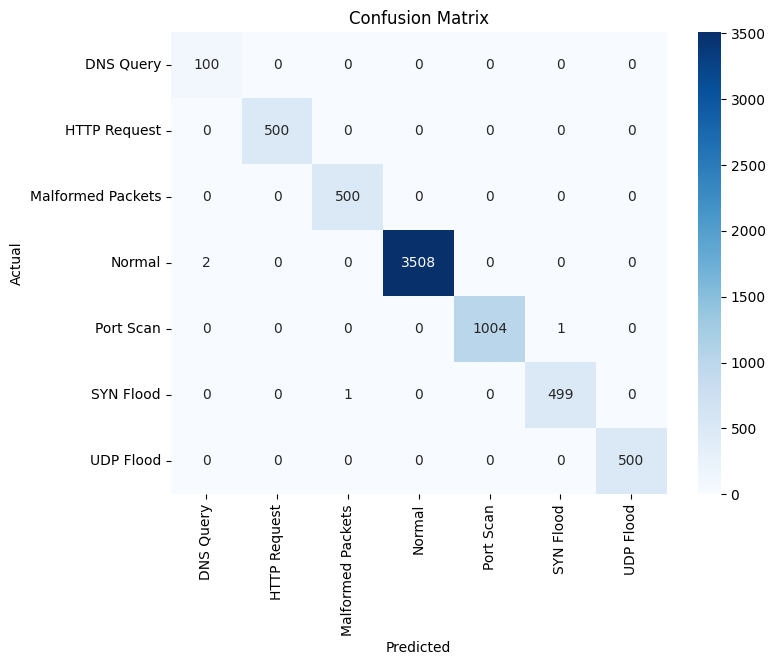

In [8]:
# 🚀 IoT Cyber Attack Detection - Model Testing on New Data (Kaggle Version)

import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the trained model
model = tf.keras.models.load_model("/kaggle/working/esp32_attack_model_optimized.h5")

# Load new dataset
new_df = pd.read_csv("/kaggle/input/dataset-test/esp32_attack_data_test.csv")

# Drop high-cardinality or less useful features
new_df = new_df.drop(columns=['Source IP', 'Destination IP', 'TCP Flags'], errors='ignore')

# Handle missing values (same method as in training)
new_df = new_df.dropna()

# Extract ground truth labels (if available)
if 'Attack Type' in new_df.columns:
    true_labels = new_df['Attack Type']
    new_df = new_df.drop(columns=['Attack Type'])
else:
    true_labels = None

# Normalize features (use same scaler from training)
scaler = StandardScaler()
X_new = scaler.fit_transform(new_df)

# Make predictions
predictions = model.predict(X_new)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Load label encoder from training phase
le = LabelEncoder()
le.classes_ = np.load("/kaggle/working/label_classes.npy", allow_pickle=True)
predicted_attack_types = le.inverse_transform(predicted_labels)

# Save predictions to CSV
output_df = pd.DataFrame({"Predicted Attack Type": predicted_attack_types})
output_df.to_csv("attack_predictions.csv", index=False)

print("✅ Predictions saved to attack_predictions.csv")


# If ground truth labels exist, calculate accuracy
if true_labels is not None:
    true_labels_encoded = le.transform(true_labels)
    accuracy = accuracy_score(true_labels_encoded, predicted_labels)
    print(f"\n🎯 Model Accuracy on New Data: {accuracy * 100:.2f}%")

    # Display classification report
    print("\n🔍 Classification Report:")
    print(classification_report(true_labels_encoded, predicted_labels, target_names=le.classes_))

    # Confusion matrix
    cm = confusion_matrix(true_labels_encoded, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()